# Lab2 - Concrete compressive strength regression
Author: *Ali Ahmed*

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 0. Function definitions

To find the best model, we follow the published article where root-mean squared error (rms) was used as a score function. The rms score function needs to be minimized, because the optimal score is 0, larger values are worse performances. 

In scikit-learn, only *maximization* is implemented. Hence, it is customary to maximize the *negative* rms. scitkit-learn provides a scoring function `neg_root_mean_squared_error`.

In [63]:
from sklearn.model_selection import cross_validate


def get_regressor_neg_rms(model, X, y, cv=7):
    '''Calculate train and validation score for regressor (model) using cross-validation
        
        score is negative root mean-squared error (rms).
        
        model (sklearn classifier): Regressor to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        
        returns: mean training negative rms, mean validation negative rms
    
    '''
    num = cv
    scores = cross_validate(model, X, y, cv=num, scoring='neg_root_mean_squared_error', return_train_score=True)
    mean_training_neg_rms= np.average(scores['train_score'])
    mean_test_neg_rms= np.average(scores['test_score'])
    
    return mean_training_neg_rms ,mean_test_neg_rms
    
    
    

## 1. Load data
yellowbrick concrete  
https://www.scikit-yb.org/en/latest/api/datasets/concrete.html

Print the README of the concrete Dataset object. Load the Dataset object by using `return_dataset=True`.


In [64]:
from yellowbrick.datasets import load_concrete
#yellowbrick.datasets.loaders.load_concrete(data_home=None, return_dataset=True)

In [65]:
dta = load_concrete(return_dataset=True)

In [66]:
print(dta.meta)

{'features': ['cement', 'slag', 'ash', 'water', 'splast', 'coarse', 'fine', 'age'], 'target': 'strength'}


In [67]:
print(dta.README)

# Concrete Compressive Strength

**Downloaded from the UCI Machine Learning Repository on October 13, 2016.**

- Multivariate Data Set
- Real Attributes
- 1,030 Instances
- 9 attributes
- Well suited for _regression_ tasks
- [https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength)

## Abstract

Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients.

## Description

Given are the variable name, variable type, the measurement unit and a brief description. The concrete compressive strength is the regression problem. The order of this listing corresponds to the order of numerals along the rows of the database.

## Attributes

- cement (kg)
- blast furnace slag (kg)
- fly ash (kg)
- water (kg)
- superplasticizer (kg)
- coarse aggregate (kg)
- fine aggregate (kg)
- age (day)
- compressive strength (MPa)

## Citat

### *Question 1:* What is the target variable name and units in this dataset?

*strenght, its units are in MPa*


### 1.1 Prepare the feature matrix and target vector
Load the concrete data set into feature matrix `X` and target vector `y`.

Print dimensions and type of `X`, `y`.

In [68]:
X,y = load_concrete()

In [69]:
print("Feature matrix dimensions are",X.shape)
print("Target vector dimensions are",y.shape)
print("Type of the featiure matrix is",X.dtypes)
print("Type of the target vector is",y.dtypes)

Feature matrix dimensions are (1030, 8)
Target vector dimensions are (1030,)
Type of the featiure matrix is cement    float64
slag      float64
ash       float64
water     float64
splast    float64
coarse    float64
fine      float64
age         int64
dtype: object
Type of the target vector is float64


## 2. Inspect the data 

### 2.1 Range of each feature
To get an idea if the features are on the same scale, we inspect the range of features.

Print the minimum and maximum of each feature in `X`.

In [70]:
print("Column cement range is from", min(X['cement']),"to", max(X['cement']))
print("Column slag range is from", min(X['slag']),"to", max(X['slag']))
print("Column ash range is from", min(X['ash']),"to", max(X['ash']))
print("Column water range is from", min(X['water']),"to", max(X['water']))
print("Column splast range is from", min(X['splast']),"to", max(X['splast']))
print("Column coarse range is from", min(X['coarse']),"to", max(X['coarse']))
print("Column fine range is from", min(X['fine']),"to", max(X['fine']))
print("Column age range is from", min(X['age']),"to", max(X['age']))

Column cement range is from 102.0 to 540.0
Column slag range is from 0.0 to 359.4
Column ash range is from 0.0 to 200.1
Column water range is from 121.75 to 247.0
Column splast range is from 0.0 to 32.2
Column coarse range is from 801.0 to 1145.0
Column fine range is from 594.0 to 992.6
Column age range is from 1 to 365


### 2.2 Boxplot of features 
Using seaborn boxplot, plot all features. This provides a visual view of feature ranges.

Add y-axis label indicating units, and a title.

[Text(0.5, 0, 'Features'),
 Text(0, 0.5, 'Ammount (kg) or Day for Age'),
 Text(0.5, 1.0, 'Feature Matrix Plot')]

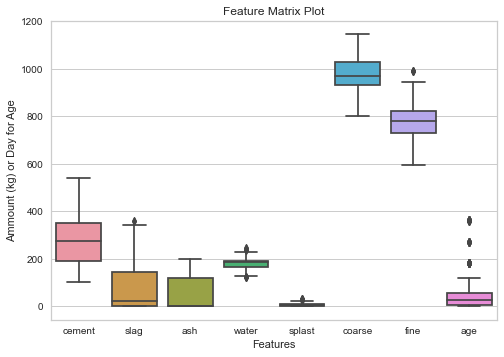

In [71]:
plott = sns.boxplot(data=X)
plott.set(xlabel ="Features", ylabel = "Ammount (kg) or Day for Age", title ='Feature Matrix Plot')

### 2.3 Correlation heatmap of features 

To understand if pairs of features are potentially related, contain similar information, pair-wise cross-correlation can be calculated. Models benefit most from un-correlated features.

Using pandas `corr()` method, create the cross-correlations between all features. Plot this cross-correlation object using seaborn `heatmap()` with parameters `vmin=-1, vmax=1, annot=True, cmap='BrBG'`. Add a title.

Pandas `corr()` calculates [Pearson correlation ](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) :
>  It has a value between +1 and −1. A value of +1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

[Text(0.5, 1.0, 'Correlation heatmap of features')]

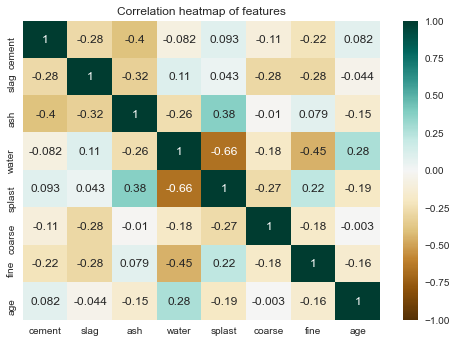

In [72]:
X_hm = X.corr()
hm = sns.heatmap(X_hm, vmin=-1, vmax=1, annot=True, cmap='BrBG')
hm.set(title ='Correlation heatmap of features')

### 2.4 Histogram of target variable 

To understand if all target values are equally represented in the data, we analyze how many samples of each target value we have available. The histogram of the target vector can visualize this distribution.

Using seaborn `displot()`, plot the histogram of the target vector. Add a title.

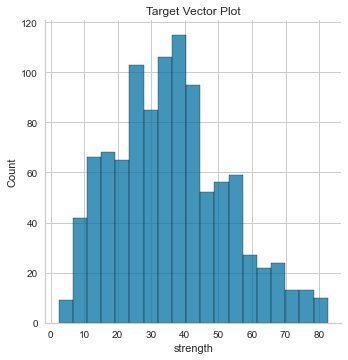

In [73]:
axs = sns.displot(data=y)
axs.set(title ='Target Vector Plot')

## 3. Create training and test sets

Using scikit-learn `train_test_split()` with parameters `random_state=37`, `test_size=0.2`, split `X` and `y` into training and test sets.

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=37,test_size=0.2)


## 4. Compare models using cross-validation

Create a list containing a `LinearRegression()`, `RandomForestRegressor(random_state=64)` and `GradientBoostingRegressor(random_state=79)` objects.

Iterate this list, compute the negative root mean-squared error using the `get_regressor_neg_rms()` function, and print the training and validation scores with **2 decimal places**. Use 7-fold cross-validation.

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

models = [LinearRegression() ,RandomForestRegressor(random_state=64), GradientBoostingRegressor(random_state=79)]
for i in models:
    [train_score ,test_score] = get_regressor_neg_rms(i, X_train, y_train)
    print('model:' , i, '\ntrain score:' ,round(train_score,2) , '\ntest_score:',round(test_score,2) ,'\n')
    

model: LinearRegression() 
train score: -10.29 
test_score: -10.39 

model: RandomForestRegressor(random_state=64) 
train score: -2.12 
test_score: -4.97 

model: GradientBoostingRegressor(random_state=79) 
train score: -3.69 
test_score: -4.98 



### *Question 2:* For each of the three models, state if models are potentially over- or underfitting and why.

model: LinearRegression() 
it is potentially underfitting, this is because both the training and tests scores are away from zero by a lot. Or maybe it is a limitaion of the model, the model doesnt match the data properly. They have high bias so maybe a better model would be more complex. 

model: RandomForestRegressor(random_state=64) 
is overfitting because the training score is much closer to zero than the test score. This is because the model is too complex and is shaped by the data points instead of the trend in the data. They have high variance so a better model would be less complex.

model: GradientBoostingRegressor(random_state=79) 
Doesnt seem to be over or underfitting, this is because the train score is better than the test socre but there isnt a huge disparity and the scores are relitively close to 0. It doesnt have high variance or high bias, it seems to be in the middle of the curve. 







## 5. Find a better model

Use the `RandomForestRegressor(random_state=64)` and find the best combination of `max_depth` from the list of `[10, 15, 20]`, and `n_estimators` from the list of `[50, 100, 150]`.

Use nested for-loops to iterate these two lists, compute the negative root mean-squared error of the corresponding `RandomForestRegressor(random_state=64)` using the `get_regressor_neg_rms()` function, and print the training and validation scores with **2 decimal places**. Use 7-fold cross-validation.

In [76]:
depth = [10 ,15 ,20]
est = [50, 100, 150]
for w in est:
    for v in depth:
        [train_score ,test_score] = get_regressor_neg_rms(RandomForestRegressor(n_estimators=w, max_depth=v, random_state=64), X_train, y_train)
        print('model:' , RandomForestRegressor(n_estimators=w, max_depth=v, random_state=64), '\ntrain score:' ,round(train_score,2) , '\ntest_score:',round(test_score,2) ,'\n')
    


model: RandomForestRegressor(max_depth=10, n_estimators=50, random_state=64) 
train score: -2.48 
test_score: -5.14 

model: RandomForestRegressor(max_depth=15, n_estimators=50, random_state=64) 
train score: -2.17 
test_score: -5.02 

model: RandomForestRegressor(max_depth=20, n_estimators=50, random_state=64) 
train score: -2.16 
test_score: -5.02 

model: RandomForestRegressor(max_depth=10, random_state=64) 
train score: -2.44 
test_score: -5.09 

model: RandomForestRegressor(max_depth=15, random_state=64) 
train score: -2.12 
test_score: -4.97 

model: RandomForestRegressor(max_depth=20, random_state=64) 
train score: -2.12 
test_score: -4.97 

model: RandomForestRegressor(max_depth=10, n_estimators=150, random_state=64) 
train score: -2.42 
test_score: -5.06 

model: RandomForestRegressor(max_depth=15, n_estimators=150, random_state=64) 
train score: -2.1 
test_score: -4.94 

model: RandomForestRegressor(max_depth=20, n_estimators=150, random_state=64) 
train score: -2.1 
test_sco

### *Question 3:* Which combination of `max_depth` and `n_estimators` produced the best validation score? Report this score here.

max_depth=20, n_estimators=150, makes the best validation scores. 

the score is:
model: RandomForestRegressor(max_depth=20, n_estimators=150, random_state=64) 
train score: -2.1 
test_score: -4.93 

Keep in mind the test_score really refers to the validation score in this case since our data is only the training data. 


## 6. Retrain best model

Create a `RandomForestRegressor(random_state=64)` with the best pair of `max_depth` and `n_estimators`, and retrain this model on all training data.

In [77]:
model = RandomForestRegressor(n_estimators=150, max_depth=20, random_state=64)
model.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, n_estimators=150, random_state=64)

## 7. Evaluate best model on training and test data
### 7.1 Root mean-squared error and R-squared

For the retrained best estimator, print the root mean-squared error (**2 decimal places**) and R-squared (**3 decimal places**) for training and test sets.

In [78]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
mse_train = sqrt(mean_squared_error(y_train_pred, y_train))
mse_test = sqrt(mean_squared_error(y_test_pred, y_test))
print('The root mean-squared error for the training and test set is', 
      '\ntraining root mean-squared error:', round(mse_train,2),
      '\ntest root mean-squared error', round(mse_test,2))
r2_train = r2_score(y_train_pred, y_train)
r2_test = r2_score(y_test_pred, y_test)
print('\nThe r2 for the training and test set is', 
      '\ntraining r2 score:', round(r2_train,3),
      '\ntest r2 score:', round(r2_test,3))


The root mean-squared error for the training and test set is 
training root mean-squared error: 2.0 
test root mean-squared error 4.87

The r2 for the training and test set is 
training r2 score: 0.984 
test r2 score: 0.893


### *Question 4:* How does this test score compare to the polynomial regression and neural network reported in the article? Do we outperform the reported models?

Only the test scores will be compared, not the training scores.

Our test socre for the root mean score error(rmse) and R2 score is better than the polynomial regression from the article. Our rmse and R2 for the test data is 4.87 MPa and 0.893. The rmse and R2 for the polynomails regression is 8.82 MPa and 0.791. 

Our test socre for the root mean score error(rmse) and R2 score is worse than the neural network from the article.Our rmse and R2 for the test data is 4.87 MPa and 0.893. The rmse and R2 for the neural network is 4.32 MPa and 0.929. 

We out performed the polynomial regression model but not the neural network model.


### 7.2 Predicted vs actual strength plot
Using a scatterplot, show predicted strength on the x axis and actual strength on the y axis with data from the test set. With this plot, we can see where we make errors.

Add a line of unity (diagonal with slope 1 and offset 0). Ideally, all points would be on this line. We look for points being distributed equally around the line of unity.

Add x-axis, y-axis labels including units, and a title.


In [79]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-',color='yellow')

#this code was taken from the following link:
#https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib

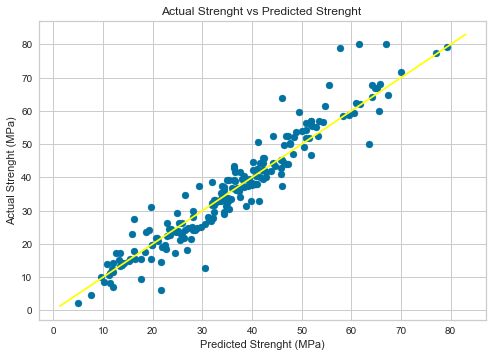

In [80]:
predvsact = plt.scatter(y_test_pred, y_test)
plt.xlabel('Predicted Strenght (MPa)')
plt.ylabel('Actual Strenght (MPa)')
plt.title('Actual Strenght vs Predicted Strenght ')
abline(1,0) #the line of unity is yellow

### 7.3 Residual plot
Using a scatterplot, show predicted strength on the x axis and the *difference* between actual and predicted strength on the y axis with data from the test set. This is an alternative way to see where errors are made.

We look for residuals being distributed equally around the zero horizontal line.

Add x-axis, y-axis labels including units, and a title.



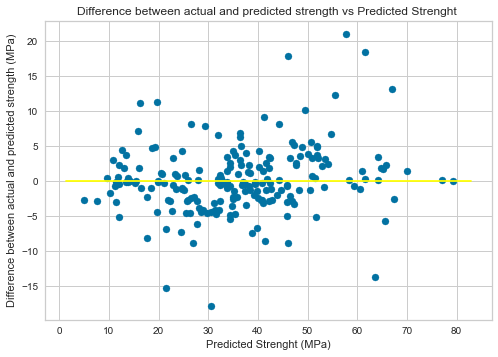

In [81]:
diff = y_test - y_test_pred
predvsact = plt.scatter(y_test_pred, diff)
plt.xlabel('Predicted Strenght (MPa)')
plt.ylabel('Difference between actual and predicted strength (MPa)')
plt.title('Difference between actual and predicted strength vs Predicted Strenght ')
abline(0,0)

## 8. Conclusion

In conclusion, comment on the following items:
- Did we find a model that outperformes the polynomial regression reported in the reference article? Explain.
- Did we find a model that outperformes the neural network reported in the reference article? Explain.
- What was the assumption about the dataset and the reference article? How does this affect your conclusions?


Our model (RandomForestRegressor(n_estimators=150, max_depth=20, random_state=64)) outperforms the polynomial regression reported in the article becasue our root mean squared error was lower and our R2 score was higher than that of the polynomail regression model. Our rmse and R2 for the test data is 4.87 MPa and 0.893. The rmse and R2 for the polynomails regression is 8.82 MPa and 0.791. 

Our model (RandomForestRegressor(n_estimators=150, max_depth=20, random_state=64)) did not outperform the neural network reported in the article becasue our root mean squared error was higher and our R2 score was lower than that of the neural network. Our rmse and R2 for the test data is 4.87 MPa and 0.893. The rmse and R2 for the neural network is 4.32 MPa and 0.929. 

I assumed the reference article used the same ammount of data in thier models that we did. We are assuming that the yellowbrick dataset was used in the reference article and that 20% of the data served as the test set. Assuming the article used the same dataset effects our results heavily becasue we can only compare models which used the same data, if they have different data then one dataset could have a lot more outliers than the other impacting one of the model more than the other. Using 20% of the data as the test set would also effect the results we get because if less data was used for the test it means the model can be trained on more data, this however would not change the results as significantly as using different datasets.  


## 9. Reflection



Include a sentence or two about:
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating while working on this assignment.

I really liked this lab becasue we used for loops to find the best model, this was something I was thinking about in class when we would input different values into the models and see which is the best performing model, it was cool to put it in action.
One thing I found challangeing about this lab was the wording on part 6. It said to use all of the training data to train the model so I assumed it meant all of the data. A way to fix this would be to state which data we should use for each section of the code. 

# Appendix: Optional - use grid search to find the best model parameters.

## Workflow overview

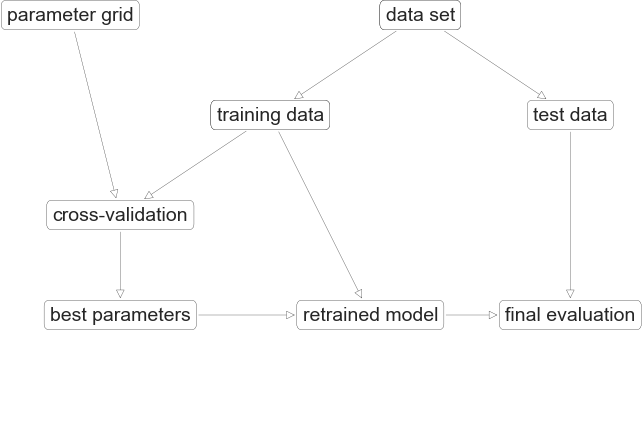

In [82]:
import mglearn
mglearn.plots.plot_grid_search_overview()

## A-1. Hyperparameter tuning using grid search 

The inital cross-validation above showed that both DecisionTree based models might have merit. Next, the hyperparameters are tuned using grid search.

### A-1.1 Grid search for RandomForestRegressor

Perform grid search using `GridSearchCV` for the `RandomForestRegressor(random_state=64)`.

Grid search to use 7-fold cross-validation, and `neg_root_mean_squared_error` as the scoring function.

Use the following hyperparameters and values:
- `'n_estimators': [100, 200, 500]`
- `'max_depth': [ 11, 13, 15, 17]`
- `'max_features': ['auto', 'log2', None]`


In [83]:
# TODO: Setup grid search for RandomForestRegressor(random_state=64)


In [84]:
# TODO: perform the grid search by calling fit()


In [85]:
# TODO: Print the best parameters


In [86]:
# TODO: Print the best score


### A-5.2 Grid search for gradient boosted tree

Perform grid search using `GridSearchCV` for the `GradientBoostingRegressor(random_state=79)`.

Grid search to use 7-fold cross-validation, and `neg_root_mean_squared_error` as the scoring function.

Use the following hyperparameters and values:
- `'n_estimators': [100, 200, 500]`
- `'max_depth': [1, 3, 5, 7]`
- `'learning_rate': [0.01, 0.1, 1.0]`

In [87]:
# TODO: Setup grid search for GradientBoostingRegressor(random_state=79)


In [88]:
# TODO: perform the grid search by calling fit()


In [89]:
# TODO: Print the best parameters


In [90]:
# TODO: Print the best score


### *Question A-1:* Which of the two models produces the best score? What is the best score?

*YOUR ANSWER HERE*


## A-2. Retrain best model

Get the best estimator from the two grid searches above and retrain this model on all training data.

In [91]:
#TODO: retrain the best estimator



## A-3. Model evaluation and conclusion

Repeat steps in Section 7 above for the best model.

Revisit your conclusion.